In [31]:
import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.tsa.api import VAR
from statsmodels.formula.api import ols
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

np.random.seed(42)

### Analisi Esplorativa dei dati

In [32]:
df = pandas.read_csv('data/corruption_df.csv')

display(df)

,geo,year,corruption,poverty,neet,education,unemployment,income,inequity
0,Austria,2016,36.22,14.964810,8.091438,34.540870,3.828207,24400,4.09
1,Belgium,2016,45.60,25.110680,13.799563,50.108248,5.316225,22267,3.85
2,Bulgaria,2016,3.12,29.330514,16.024476,23.464412,3.648430,3212,7.69
3,Cyprus,2016,4.83,1.917201,1.526974,4.767553,0.729554,14132,4.88
4,Czechia,2016,28.04,13.086765,11.714766,34.405528,2.743999,7905,3.50
...,...,...,...,...,...,...,...,...,...
157,Portugal,2021,2.06,23.068084,9.783339,48.916697,4.531231,11115,5.66
158,Romania,2021,20.92,66.245734,38.979374,44.739872,6.144532,4914,7.14
159,Sweden,2021,205.03,17.852387,6.227577,51.169924,6.746542,25925,4.04
160,Slovenia,2021,11.38,2.783850,1.539553,10.102000,0.653783,15415,3.24


<Axes: >

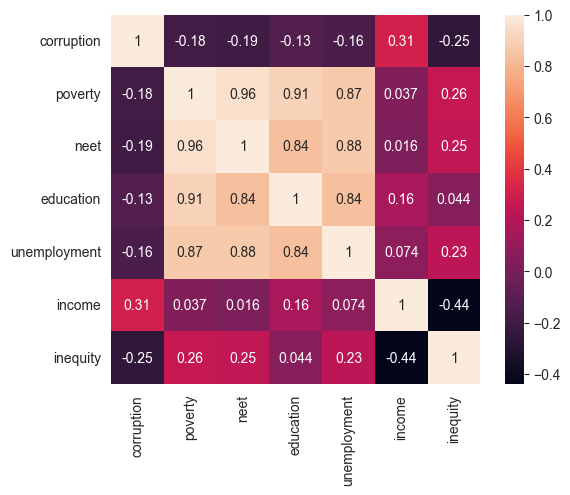

In [33]:
# Correlation Matrix

corrmat = df.drop(columns=["geo", "year"]).corr()

sns.heatmap(corrmat, square=True, annot=True)

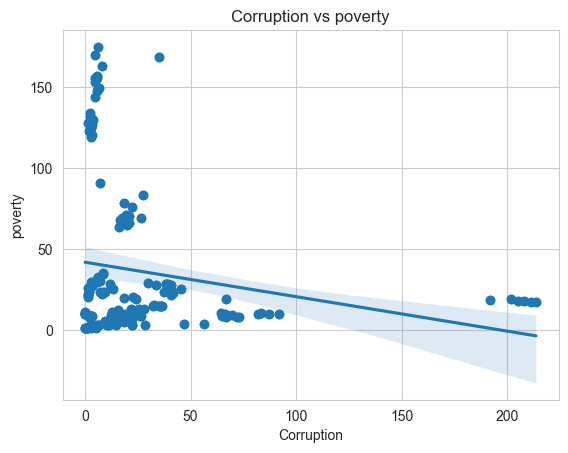

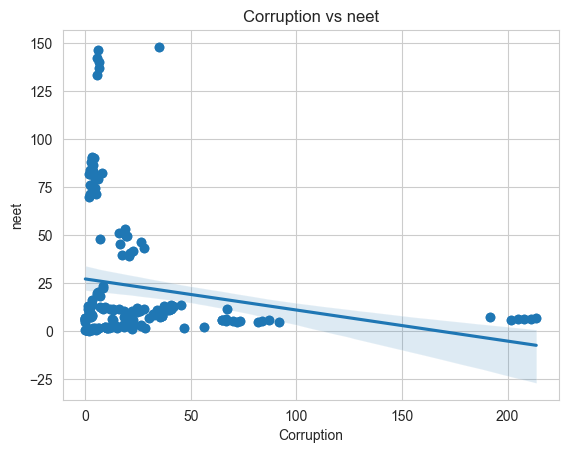

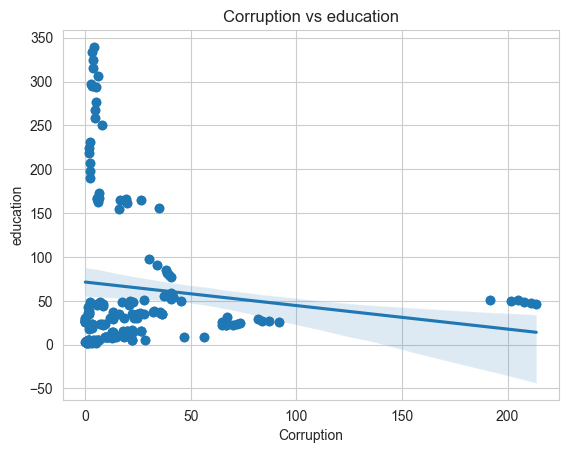

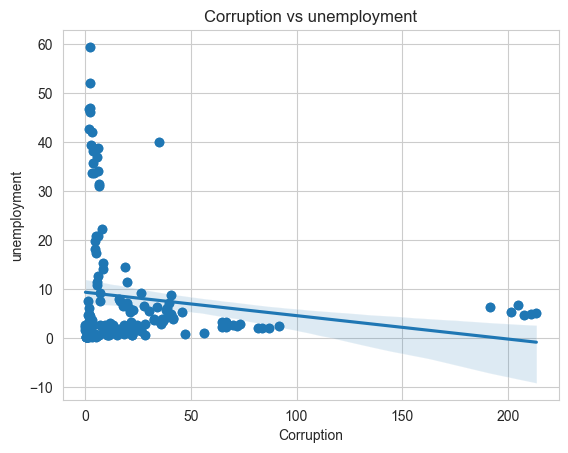

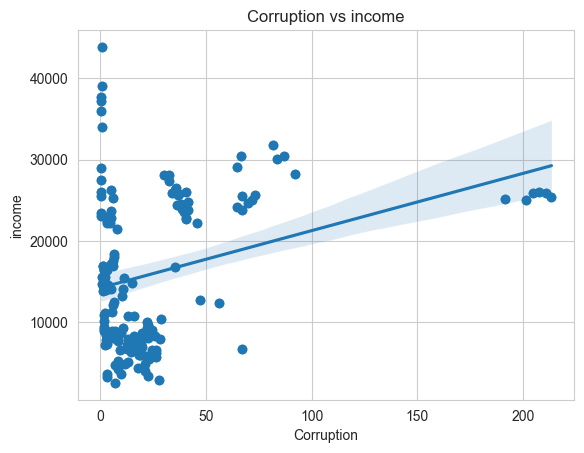

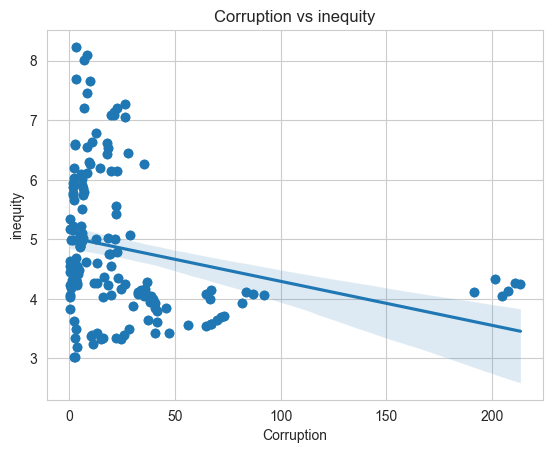

In [34]:
# Scatter Plot
features = ["poverty", "neet", "education", "unemployment", "income", "inequity"]

for feature in features:
    sns.regplot(x="corruption", y=feature, data=df)
    plt.scatter(df["corruption"], df[feature])
    plt.xlabel("Corruption")
    plt.ylabel(feature)
    plt.title("Corruption vs " + feature)
    plt.show()


# Modeling

In [35]:
X = df.drop(columns=["geo", "year", "corruption"])
y = df["corruption"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test, y_test)

0.03129101481830876

In [36]:
# ANOVA Model
model = ols("corruption ~ poverty + neet + education + unemployment + income + inequity", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                     sum_sq     df          F    PR(>F)
poverty          744.284999    1.0   0.501854  0.479751
neet            1458.802122    1.0   0.983636  0.322848
education       1290.339418    1.0   0.870046  0.352393
unemployment     109.091874    1.0   0.073558  0.786586
income         16264.607686    1.0  10.966848  0.001154
inequity        2529.617423    1.0   1.705662  0.193484
Residual      229875.915471  155.0        NaN       NaN


In [37]:
X2 = sm.add_constant(df.drop(columns=["geo", "year", "corruption"]))
model = sm.OLS(y, X2)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             corruption   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     4.469
Date:                Thu, 02 Nov 2023   Prob (F-statistic):           0.000335
Time:                        16:57:35   Log-Likelihood:                -817.74
No. Observations:                 162   AIC:                             1649.
Df Residuals:                     155   BIC:                             1671.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           31.8473     19.195      1.659   

In [38]:
hypothesis_0 = "poverty = 0, neet = 0, education = 0, unemployment = 0, income = 0, inequity = 0"
print(results.wald_test(hypothesis_0))


<F test: F=array([[4.46939241]]), p=0.000334649929504683, df_denom=155, df_num=6>


C:\Workspace\test\venv\Lib\site-packages\statsmodels\base\model.py:1906: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


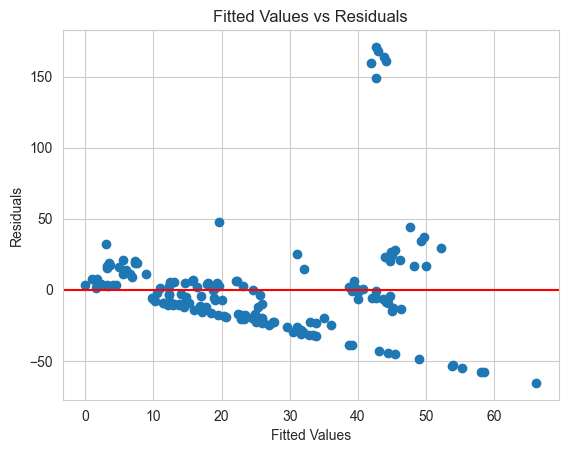

In [39]:
plt.scatter(results.fittedvalues, results.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted Values vs Residuals")
plt.axhline(y=0, color="red")
plt.show()

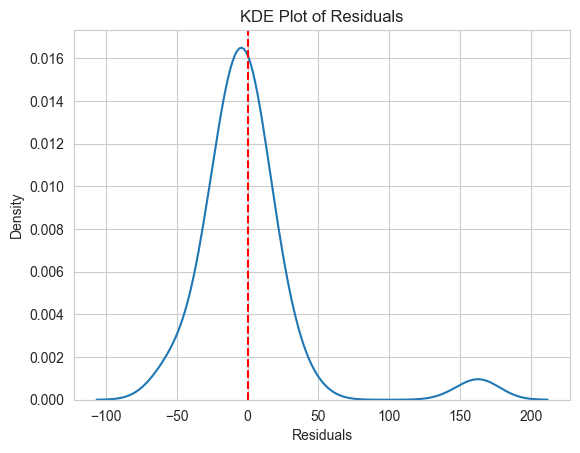

In [40]:
# KDE Plot of residuals
sns.kdeplot(results.resid)
plt.axvline(results.resid.mean(), linestyle='dashed', color="red")
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.title("KDE Plot of Residuals")
plt.show()

In [41]:
#sm.graphics.plot_partregress_grid(results)

### Top 5 regions with the highest corruption in total

In [42]:
data = df.drop(columns=["poverty", "neet", "education", "unemployment", "income", "inequity"])
display(data.groupby("geo").sum().sort_values(by="corruption", ascending=False).head(5))

,year,corruption
geo,,
Sweden,12111,1230.60
Denmark,12111,475.64
Finland,12111,413.14
Belgium,12111,247.28
Netherlands,12111,220.82


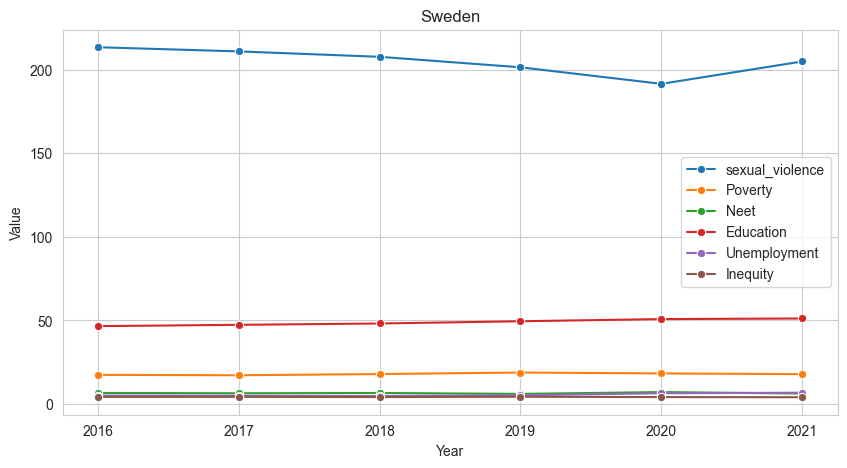

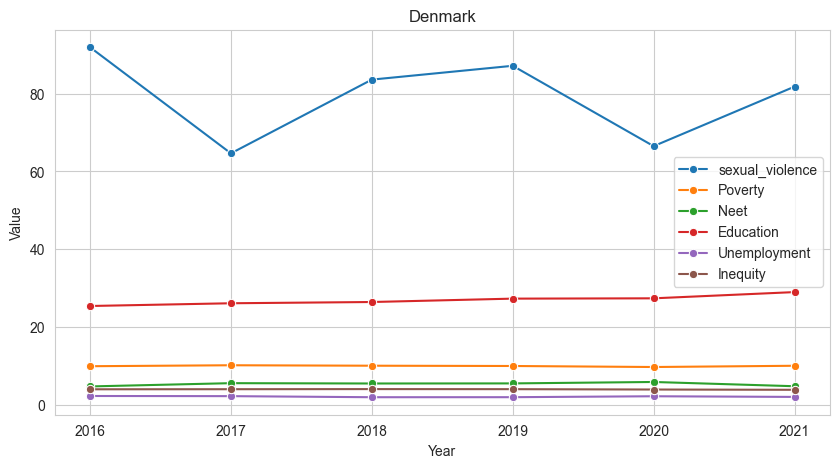

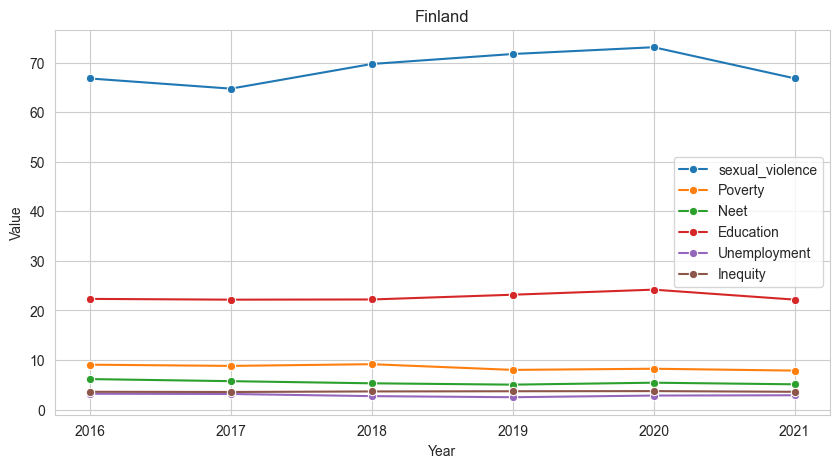

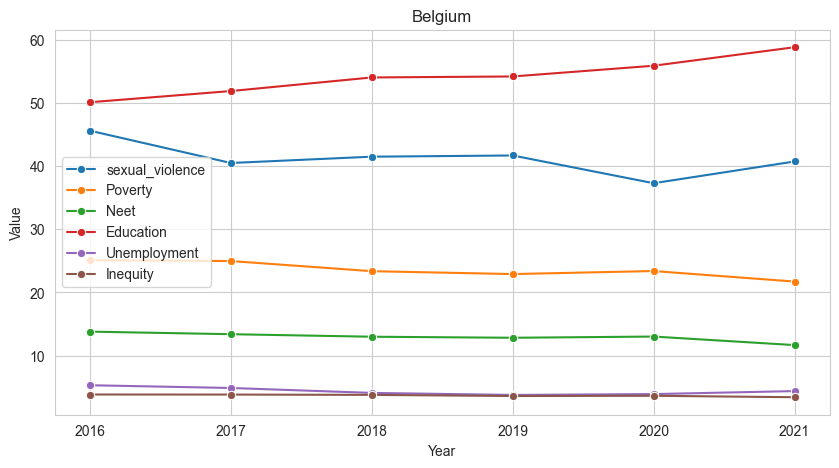

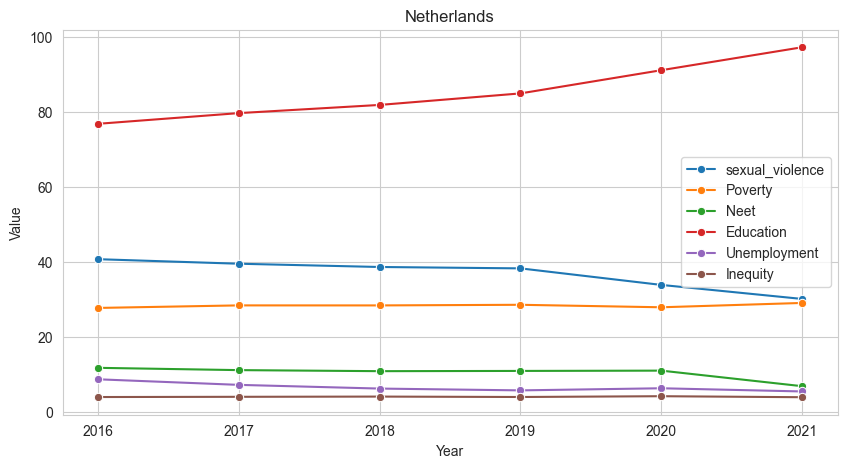

In [43]:
# Data Visualization

sweden = df[df["geo"] == "Sweden"]
danmark = df[df["geo"] == "Denmark"]
finland = df[df["geo"] == "Finland"]
belgium = df[df["geo"] == "Belgium"]
netherlands = df[df["geo"] == "Netherlands"]

countries = [sweden, danmark, finland, belgium, netherlands]

for country in countries:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x="year", y="corruption", data=country, label="sexual_violence", marker="o")
    sns.lineplot(x="year", y="poverty", data=country, label="Poverty", marker="o")
    sns.lineplot(x="year", y="neet", data=country, label="Neet", marker="o")
    sns.lineplot(x="year", y="education", data=country, label="Education", marker="o")
    sns.lineplot(x="year", y="unemployment", data=country, label="Unemployment", marker="o")
#    sns.lineplot(x="year", y="income", data=country, label="Income", marker="o")
    sns.lineplot(x="year", y="inequity", data=country, label="Inequity", marker="o")
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.title(country["geo"].iloc[0])
    plt.show()